# Deep Learning for Neural Decoding


Neural decoding uses activity recorded from the brain to make predictions about variables in the outside world or put simply put, it is a mathematical mapping from the brain activity to the outside world. For example, we may predict movements based on activity in the motor cortex, decisions based on activity in prefrontal and parietal cortices, and spatial locations based on activity in hippocampus. As deep learning methods have become more popular over the last decade people have experimented with them to test how effective they are as neural decoders.

The motivation behind this paper is that improving the performance of neural decoding algorithms allow neuroscientists to better understand information contained in a neural population and can help advance brain machine interfaces and thus it is very important to discuss what these neural decoders do and what their limitations are.


In this project I compare three different methods for neural decoding and present several graphs to compare their performance. The sample dataset I will be working on will come from this paper (example_data_hc.pickle) which is recordings animal hippocampus. They have published their code opensource on github (https://github.com/KordingLab/Neural_Decoding). I did not change some of the functionalities like data preprocessing step and the scoring functions. I have used hippocampus data purposefully because I expect there to a non-linear relationship between the input and the output. Hippocampus has a major role in learning and memory. In the last part of the project I discuss the effectiveness of deap learning models in neural decoding and the limitations of decoders in general.

In [156]:
############### IMPORT PACKAGES ##################
import numpy as np
import keras
keras_v1=int(keras.__version__[0])<=1
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, BatchNormalization, SimpleRNN
from keras.utils import np_utils
import matplotlib.pyplot as plt
import pickle

## Data Formatting and Preprocessing


There arises a problem when time is continously recorded, but decoding methods require discrete data for their inputs and in the continual predcition situation, their outputs. A solution for this is to divide both inputs and outputs into discrete time bins.  When predictions are desired continously in time, you need to decide on a temporal resolution, R, for decoding which ks the time interval for when we want to make a prediction. If T is the length of the recording, we will have approximately T/R total data points of neural activity and outputs. When we are choosing the time period of neural activity used to predict a given output, we want the neural data to precede the output or follow the decoder output. Thus we will be predicting K total output bins where K is less than the total number of bins T/R. To summarize, the decoder will be predicting each of these K outputs using B surrounding bins of activity from N neurons. 


The N x B features (the firing rates of each neuron in each relevant time bin) are used to predict each output. The input matrix of covariates, X, has N x B columns and K rows that correspond to the output. Since there are multiple outputs being predicted the output can be put in a matrix Y, that has K rows and d columns, where d is the number of outputs being predicted. **get_spikes_with_history(...)** does exactly this by creating a covariate matrix of neural activity.

In [ ]:
##### GET_SPIKES_WITH_HISTORY #####
def get_spikes_with_history(neural_data,bins_before,bins_after,bins_current=1):
    """
    Function that creates the covariate matrix of neural activity
    Parameters
    ----------
    neural_data: a matrix of size "number of time bins" x "number of neurons"
        the number of spikes in each time bin for each neuron
    bins_before: integer
        How many bins of neural data prior to the output are used for decoding
    bins_after: integer
        How many bins of neural data after the output are used for decoding
    bins_current: 0 or 1, optional, default=1
        Whether to use the concurrent time bin of neural data for decoding
    Returns
    -------
    X: a matrix of size "number of total time bins" x "number of surrounding time bins used for prediction" x "number of neurons"
        For every time bin, there are the firing rates of all neurons from the specified number of time bins before (and after)
    """

    num_examples=neural_data.shape[0] #Number of total time bins we have neural data for
    num_neurons=neural_data.shape[1] #Number of neurons
    surrounding_bins=bins_before+bins_after+bins_current #Number of surrounding time bins used for prediction
    X=np.empty([num_examples,surrounding_bins,num_neurons]) #Initialize covariate matrix with NaNs
    X[:] = np.NaN
    #Loop through each time bin, and collect the spikes occurring in surrounding time bins
    #Note that the first "bins_before" and last "bins_after" rows of X will remain filled with NaNs, since they don't get filled in below.
    #This is because, for example, we cannot collect 10 time bins of spikes before time bin 8
    start_idx=0
    for i in range(num_examples-bins_before-bins_after): #The first bins_before and last bins_after bins don't get filled in
        end_idx=start_idx+surrounding_bins; #The bins of neural data we will be including are between start_idx and end_idx (which will have length "surrounding_bins")
        X[i+bins_before,:,:]=neural_data[start_idx:end_idx,:] #Put neural data from surrounding bins in X, starting at row "bins_before"
        start_idx=start_idx+1;
    return X

In [ ]:
def get_R2(y_test,y_test_pred):

    """
    This is the scoring function (L2 norm) which computes the euclidian distance between predicted and ground truth
    Parameters
    ----------
    y_test - the true outputs (a matrix of size number of examples x number of outputs)
    y_test_pred - the predicted outputs (a matrix of size number of examples x number of outputs)
    Returns
    -------
    R2_array: An array of R2s for each output
    """

    R2_list=[] #Initialize a list that will contain the R2s for all the outputs
    for i in range(y_test.shape[1]): #Loop through outputs
        #Compute R2 for each output
        y_mean=np.mean(y_test[:,i])
        R2=1-np.sum((y_test_pred[:,i]-y_test[:,i])**2)/np.sum((y_test[:,i]-y_mean)**2)
        R2_list.append(R2) #Append R2 of this output to the list
    R2_array=np.array(R2_list)
    return R2_array #Return an array of R2s


## Constructing and Training Neural Decoders  

Below is the feedforward neural network architecture. The hyperparameters are the number of hidden layers in each layer (units), dropout which is the proportion of units that gets dropped out, and number of epochs. I have set the units to be 400, the dropout to be 0, and the number epochs to 10. This can be changed and initialized in the __init__ function. I have used a linear layer, batch normalization layer, a dropout layer if specified, and finally an relu activation layer which allows to introduce non-linearity to the network. I add all these layer in the **fit(...)** function. The **predict(...)** function simply does calls keras.model library's predict function which calculates the output values. For the loss function we use mean squared error, $\frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$ where $Y_i$ is the observed values and $\hat{Y_i}$ is the predicted values. Finally we use adam optimizer which uses momentum and exponentially weighted average for backpropogation.

The dense decoder has the form 

$H_1 = ReLU(W_1 X+b_1)$

$H_2 = ReLU(W_2 H_1+b_2)$

$Y= W_3 H_2+b_3$

where $H_i$ is the hidden layer/s and $Y$ is the output layer. In the hidden layers we use a ReLU function to introduce non-linearity to our model and our output layer is a fully connected linear layer. The model learns the weights and biases for these layers which are the $W$'s and $b$'s. 

In [ ]:
##################### DENSE (FULLY-CONNECTED) NEURAL NETWORK ##########################

class DenseNNDecoder(object):

    """
    Class for the dense (fully-connected) neural network decoder
    Parameters
    ----------
    units: integer or vector of integers, optional, default 400
        This is the number of hidden units in each layer
        If you want a single layer, input an integer (e.g. units=400 will give you a single hidden layer with 400 units)
        If you want multiple layers, input a vector (e.g. units=[400,200]) will give you 2 hidden layers with 400 and 200 units, repsectively.
        The vector can either be a list or an array
    dropout: decimal, optional, default 0
        Proportion of units that get dropped out
    num_epochs: integer, optional, default 10
        Number of epochs used for training
    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=200,dropout=0,num_epochs=5,verbose=1):
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose

         #If "units" is an integer, put it in the form of a vector
         try: #Check if it's a vector
             units[0]
         except: #If it's not a vector, create a vector of the number of units for each layer
             units=[units]
         self.units=units

         #Determine the number of hidden layers (based on "units" that the user entered)
         self.num_layers=len(units)

    def fit(self,X_flat_train,y_train):

        """
        Train DenseNN Decoder
        Parameters
        ----------
        X_flat_train: numpy 2d array of shape [n_samples,n_features]
            This is the neural data.
            See example file for an example of how to format the neural data correctly
        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        model=Sequential() #Declare model
        #Add first hidden layer
        model.add(Dense(self.units[0],input_dim=X_flat_train.shape[1])) #Add dense layer
        model.add(BatchNormalization())
        model.add(Activation('relu')) #Add nonlinear (tanh) activation
        # if self.dropout!=0:
        if self.dropout!=0: model.add(Dropout(self.dropout))  #Dropout some units if proportion of dropout != 0

        #Add any additional hidden layers (beyond the 1st)
        for layer in range(self.num_layers-1): #Loop through additional layers
            model.add(Dense(self.units[layer+1])) #Add dense layer
            model.add(Activation('relu')) #Add nonlinear (tanh) activation
            if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units if proportion of dropout != 0

        #Add dense connections to all outputs
        model.add(Dense(y_train.shape[1])) #Add final dense layer (connected to outputs)

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy']) #Set loss function and optimizer
        model.fit(X_flat_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_flat_test):

        """
        Predict outcomes using trained DenseNN Decoder
        Parameters
        ----------
        X_flat_test: numpy 2d array of shape [n_samples,n_features]
            This is the neural data being used to predict outputs.
        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted = self.model.predict(X_flat_test) #Make predictions
        return y_test_predicted


The linear decoder has the form 

$H_1 = W_1 X+b_1$

$H_2 = W_2 H_1+b_2$

$Y= W_3 H_2+b_3$

where $H_i$ is the hidden layer/s and $Y$ is the output layer. The only difference from the dense decoder is that it does not have an activation function. This means that the neural network is a combination of linear operations.

In [ ]:
##################### LINEAR (FULLY-CONNECTED) NEURAL NETWORK ##########################

class LinearNNDecoder(object):

    def __init__(self,units=200,dropout=0,num_epochs=5,verbose=1):
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose

         #If "units" is an integer, put it in the form of a vector
         try: #Check if it's a vector
             units[0]
         except: #If it's not a vector, create a vector of the number of units for each layer
             units=[units]
         self.units=units

         #Determine the number of hidden layers (based on "units" that the user entered)
         self.num_layers=len(units)

    def fit(self,X_flat_train,y_train):

        model=Sequential() #Declare model
        #Add first hidden layer
        model.add(Dense(self.units[0],input_dim=X_flat_train.shape[1])) #Add dense layer
        #We do not add a nonlinear activation
        # if self.dropout!=0:
        if self.dropout!=0: model.add(Dropout(self.dropout))  #Dropout some units if proportion of dropout != 0


        #Add dense connections to all outputs
        model.add(Dense(y_train.shape[1])) #Add final dense layer (connected to outputs)

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy']) #Set loss function and optimizer
        model.fit(X_flat_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_flat_test):

        y_test_predicted = self.model.predict(X_flat_test) #Make predictions
        return y_test_predicted


The recurrent decoder has the form 

$H_t = UX_t+WH_{t-1}+b$

$Y_t= VH_t+c$

where t is the timestep $H_t$ the hidden later and $Y_t$ is the output layer. The model learns the weights $U, W, V$ and the biases $b,c$.An alternative way to think view this model is that the hidden state feeds back on itself across time points. Everything else is same as the dense decoder.

In [ ]:
##################### SIMPLE RECURRENT NEURAL NETWORK ##########################

class SimpleRNNDecoder(object):

    """
    Class for the simple recurrent neural network decoder
    Parameters
    ----------
    units: integer, optional, default 400
        Number of hidden units in each layer
    dropout: decimal, optional, default 0
        Proportion of units that get dropped out
    num_epochs: integer, optional, default 10
        Number of epochs used for training
    verbose: binary, optional, default=0
        Whether to show progress of the fit after each epoch
    """

    def __init__(self,units=200,dropout=0,num_epochs=5,verbose=1):
         self.units=units
         self.dropout=dropout
         self.num_epochs=num_epochs
         self.verbose=verbose


    def fit(self,X_train,y_train):

        """
        Train SimpleRNN Decoder
        Parameters
        ----------
        X_train: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data.
            See example file for an example of how to format the neural data correctly
        y_train: numpy 2d array of shape [n_samples, n_outputs]
            This is the outputs that are being predicted
        """

        model=Sequential() #Declare model
        #Add recurrent layer
        if keras_v1:
            model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout_W=self.dropout,dropout_U=self.dropout,activation='relu')) #Within recurrent layer, include dropout
        else:
            model.add(SimpleRNN(self.units,input_shape=(X_train.shape[1],X_train.shape[2]),dropout=self.dropout,recurrent_dropout=self.dropout,activation='relu')) #Within recurrent layer, include dropout
        if self.dropout!=0: model.add(Dropout(self.dropout)) #Dropout some units (recurrent layer output units)

        #Add dense connections to output layer
        model.add(Dense(y_train.shape[1]))

        #Fit model (and set fitting parameters)
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy']) #Set loss function and optimizer
        if keras_v1:
            model.fit(X_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model
        else:
            model.fit(X_train,y_train,epochs=self.num_epochs,verbose=self.verbose) #Fit the model
        self.model=model


    def predict(self,X_test):

        """
        Predict outcomes using trained SimpleRNN Decoder
        Parameters
        ----------
        X_test: numpy 3d array of shape [n_samples,n_time_bins,n_neurons]
            This is the neural data being used to predict outputs.
        Returns
        -------
        y_test_predicted: numpy 2d array of shape [n_samples,n_outputs]
            The predicted outputs
        """

        y_test_predicted = self.model.predict(X_test) #Make predictions
        return y_test_predicted




Below we set the bins_before, bins_current and bins_after and flatten the X values. We also preprocess the hippocampus data and create the cross-validation folds. Finally we create lists for actual data, test prediction, train prediction, validation prediction for each decoder.

In [157]:
with open('example_data_hc.pickle','rb') as f:
    neural_data,pos_binned=pickle.load(f)

bins_before=4 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=5 #How many bins of neural data after (and including) the output are used for decoding


#Remove neurons with too few spikes in HC dataset
nd_sum=np.nansum(neural_data,axis=0)
rmv_nrn=np.where(nd_sum<100)
neural_data=np.delete(neural_data,rmv_nrn,1)

# Function to get the covariate matrix that includes spike history from previous bins
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

#Put in "flat" format, so each "neuron / time" is a single feature
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

y=pos_binned


#Remove time bins with no output (y value)
rmv_time=np.where(np.isnan(y[:,0]) | np.isnan(y[:,1]))
X=np.delete(X,rmv_time,0)
X_flat=np.delete(X_flat,rmv_time,0)
y=np.delete(y,rmv_time,0)


# In hippocampus dataset, there is a long period without movement starting at ~80%, so we only use the first 80% of the data
X=X[:int(.8*X.shape[0]),:,:]
X_flat=X_flat[:int(.8*X_flat.shape[0]),:]
y=y[:int(.8*y.shape[0]),:]



#There are 10 cross-validation folds. In each fold, 10% of the data is a test set, 10% is a validation set, 
#and 80% is the training set. So in the first fold, for example, 0-10% is validation, 10-20% is testing, and 20-100% is training.

valid_range_all=[[0,.1],[.1,.2],[.2,.3],[.3,.4],[.4,.5],
                 [.5,.6],[.6,.7],[.7,.8],[.8,.9],[.9,1]]
testing_range_all=[[.1,.2],[.2,.3],[.3,.4],[.4,.5],[.5,.6],
                 [.6,.7],[.7,.8],[.8,.9],[.9,1],[0,.1]]
#Note that the training set is not aways contiguous. For example, in the second fold, the training set has 0-10% and 30-100%.
#In that example, we enter of list of lists: [[0,.1],[.3,1]]
training_range_all=[[[.2,1]],[[0,.1],[.3,1]],[[0,.2],[.4,1]],[[0,.3],[.5,1]],[[0,.4],[.6,1]],
                   [[0,.5],[.7,1]],[[0,.6],[.8,1]],[[0,.7],[.9,1]],[[0,.8]],[[.1,.9]]]

num_folds=len(valid_range_all) #Number of cross validation folds

mean_r2_dnn=np.empty(num_folds)
mean_r2_lnn=np.empty(num_folds)
mean_r2_rnn=np.empty(num_folds)


#Actual data
y_test_all=[]
y_train_all=[]
y_valid_all=[]

#Test predictions
y_pred_dnn_all=[]
y_pred_lnn_all=[]
y_pred_rnn_all=[]


#Training predictions
y_train_pred_dnn_all=[]
y_train_pred_lnn_all=[]
y_train_pred_rnn_all=[]

#Validation predictions
y_valid_pred_dnn_all=[]
y_valid_pred_lnn_all=[]
y_valid_pred_rnn_all=[]

num_examples=X.shape[0] #number of examples (rows in the X matrix)

This is the main part where we first split the data into training/testing/validation, again preprocess the data, and train each of our decoders.

In [ ]:
for i in range(num_folds): #Loop through the folds

    ######### SPLIT DATA INTO TRAINING/TESTING/VALIDATION #########
    
    #Note that all sets have a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
    #This makes it so that the different sets don't include overlapping neural data
    
    #Get testing set for this fold
    testing_range=testing_range_all[i]
    testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)

    #Get validation set for this fold
    valid_range=valid_range_all[i]
    valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

    #Get training set for this fold. 
    #Note this needs to take into account a non-contiguous training set (see section 3C)
    training_ranges=training_range_all[i]
    for j in range(len(training_ranges)): #Go through different separated portions of the training set
        training_range=training_ranges[j]
        if j==0: #If it's the first portion of the training set, make it the training set
            training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
        if j==1: #If it's the second portion of the training set, concatentate it to the first
            training_set_temp=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
            training_set=np.concatenate((training_set,training_set_temp),axis=0)
                
    #Get training data
    X_train=X[training_set,:,:]
    X_flat_train=X_flat[training_set,:]
    y_train=y[training_set,:]
    
    #Get testing data
    X_test=X[testing_set,:,:]
    X_flat_test=X_flat[testing_set,:]
    y_test=y[testing_set,:]

    #Get validation data
    X_valid=X[valid_set,:,:]
    X_flat_valid=X_flat[valid_set,:]
    y_valid=y[valid_set,:]



    ##### PREPROCESS DATA #####
    
    #Z-score "X" inputs. 
    X_train_mean=np.nanmean(X_train,axis=0) #Mean of training data
    X_train_std=np.nanstd(X_train,axis=0) #Stdev of training data
    X_train=(X_train-X_train_mean)/X_train_std #Z-score training data
    X_test=(X_test-X_train_mean)/X_train_std #Preprocess testing data in same manner as training data
    X_valid=(X_valid-X_train_mean)/X_train_std #Preprocess validation data in same manner as training data

    #Z-score "X_flat" inputs. 
    X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
    X_flat_train_std=np.nanstd(X_flat_train,axis=0)
    X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std
    X_flat_test=(X_flat_test-X_flat_train_mean)/X_flat_train_std
    X_flat_valid=(X_flat_valid-X_flat_train_mean)/X_flat_train_std

    #Zero-center outputs
    y_train_mean=np.nanmean(y_train,axis=0) #Mean of training data outputs
    y_train=y_train-y_train_mean #Zero-center training output
    y_test=y_test-y_train_mean #Preprocess testing data in same manner as training data
    y_valid=y_valid-y_train_mean #Preprocess validation data in same manner as training data


    #Z-score outputs (for SVR)
    y_train_std=np.nanstd(y_train,axis=0)
    y_zscore_train=y_train/y_train_std
    y_zscore_test=y_test/y_train_std
    y_zscore_valid=y_valid/y_train_std    
    

    #Add actual train/valid/test data to lists (for saving)
    y_test_all.append(y_test)
    y_train_all.append(y_train)
    y_valid_all.append(y_valid)


    print("\n") 
    print("DenseNNDecoder")
    model_dnn=DenseNNDecoder()
    model_dnn.fit(X_flat_train,y_train)
    y_test_predicted_dnn=model_dnn.predict(X_flat_test)
    mean_r2_dnn[i]=np.mean(get_R2(y_test,y_test_predicted_dnn))    
    #Print R2 values on test set
    R2s_dnn=get_R2(y_test,y_test_predicted_dnn)
    print('R2-dnn:', R2s_dnn)    
    #Add predictions of training/validation/testing to lists (for saving)            
    y_pred_dnn_all.append(y_test_predicted_dnn)
    y_train_pred_dnn_all.append(model_dnn.predict(X_flat_train))
    y_valid_pred_dnn_all.append(model_dnn.predict(X_flat_valid))


    print("\n") 
    print("LinearNNDecoder")
    model_lnn=LinearNNDecoder()
    model_lnn.fit(X_flat_train,y_train)
    y_test_predicted_lnn=model_lnn.predict(X_flat_test)
    mean_r2_lnn[i]=np.mean(get_R2(y_test,y_test_predicted_lnn))    
    #Print R2 values on test set
    R2s_lnn=get_R2(y_test,y_test_predicted_lnn)
    print('R2-lnn:', R2s_lnn)    
    #Add predictions of training/validation/testing to lists (for saving)            
    y_pred_lnn_all.append(y_test_predicted_lnn)
    y_train_pred_lnn_all.append(model_lnn.predict(X_flat_train))
    y_valid_pred_lnn_all.append(model_lnn.predict(X_flat_valid))



    print("\n") 
    print("SimpleRNNDecoder")
    model_rnn=SimpleRNNDecoder()
    model_rnn.fit(X_train,y_train)
    y_test_predicted_rnn=model_rnn.predict(X_test)
    mean_r2_rnn[i]=np.mean(get_R2(y_test,y_test_predicted_rnn))    
    #Print R2 values on test set
    R2s_rnn=get_R2(y_test,y_test_predicted_rnn)
    print('R2s:', R2s_rnn)
    #Add predictions of training/validation/testing to lists (for saving)           
    y_pred_rnn_all.append(y_test_predicted_rnn)
    y_train_pred_rnn_all.append(model_rnn.predict(X_train))
    y_valid_pred_rnn_all.append(model_rnn.predict(X_valid)) 


    with open('results_dnn.pickle','wb') as f:
        pickle.dump([mean_r2_dnn,y_pred_dnn_all,y_train_pred_dnn_all,y_valid_pred_dnn_all],f)

    with open('results_lnn.pickle','wb') as f:
        pickle.dump([mean_r2_lnn,y_pred_lnn_all,y_train_pred_lnn_all,y_valid_pred_lnn_all],f)

    with open('results_rnn.pickle','wb') as f:
        pickle.dump([mean_r2_rnn,y_pred_rnn_all,y_train_pred_rnn_all,y_valid_pred_rnn_all],f)


#Save ground truth results
with open('ground_truth.pickle','wb') as f:
    pickle.dump([y_test_all,y_train_all,y_valid_all],f)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the 



DenseNNDecoder
Epoch 1/5
557/557 [==============================] - 2s 3ms/step - loss: 1421.8107 - accuracy: 0.7668
Epoch 2/5
557/557 [==============================] - 1s 2ms/step - loss: 1070.1357 - accuracy: 0.7913
Epoch 3/5
557/557 [==============================] - 1s 2ms/step - loss: 988.1005 - accuracy: 0.8045
Epoch 4/5
557/557 [==============================] - 1s 2ms/step - loss: 954.8758 - accuracy: 0.8064
Epoch 5/5
557/557 [==============================] - 1s 2ms/step - loss: 901.1027 - accuracy: 0.8153
R2-dnn: [0.34126461 0.56781745]


LinearNNDecoder
Epoch 1/5
557/557 [==============================] - 1s 2ms/step - loss: 1339.0527 - accuracy: 0.7738
Epoch 2/5
557/557 [==============================] - 1s 2ms/step - loss: 1243.8276 - accuracy: 0.7803
Epoch 3/5
557/557 [==============================] - 1s 2ms/step - loss: 1237.5791 - accuracy: 0.7835
Epoch 4/5
557/557 [==============================] - 1s 2ms/step - loss: 1234.5898 - accuracy: 0.7795
Epoch 5/5
557/557 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations




DenseNNDecoder
Epoch 1/5
557/557 [==============================] - 2s 2ms/step - loss: 1508.3582 - accuracy: 0.7560
Epoch 2/5
557/557 [==============================] - 1s 2ms/step - loss: 1142.3676 - accuracy: 0.7880
Epoch 3/5
557/557 [==============================] - 1s 2ms/step - loss: 1067.7986 - accuracy: 0.8010
Epoch 4/5
557/557 [==============================] - 1s 2ms/step - loss: 1016.7325 - accuracy: 0.8029
Epoch 5/5
557/557 [==============================] - 1s 2ms/step - loss: 970.2701 - accuracy: 0.8113
R2-dnn: [0.50955998 0.65665821]


LinearNNDecoder
Epoch 1/5
557/557 [==============================] - 1s 2ms/step - loss: 1417.0123 - accuracy: 0.7619
Epoch 2/5
557/557 [==============================] - 1s 2ms/step - loss: 1317.7572 - accuracy: 0.7703
Epoch 3/5
557/557 [==============================] - 1s 2ms/step - loss: 1311.6943 - accuracy: 0.7718
Epoch 4/5
557/557 [==============================] - 1s 2ms/step - loss: 1309.7017 - accuracy: 0.7765
Epoch 5/5
557/55

## Data Analysis and Comparison

Below I have plotted the predicted x velocity of the decoders (meaning the firing rate of neurons over time) and the ground truth for the x velocity. The first three graphs compare the ground truth with predicted value for each decoder in the testing dataset. The next three graphs compare ground truth with predicted value for each decoder in the training dataset. The last three graphs compare ground truth with predicted value for each decoder in validation dataset.

### Testing Dataset Comparison


Text(0.5, 1.0, 'Ground Truth (blue) vs. DNN Predicted (purple)')

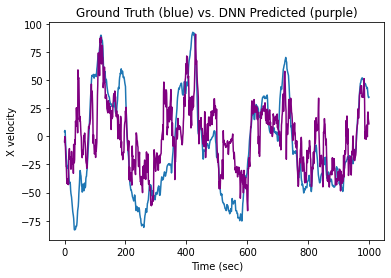

In [136]:
#The blue graph is the ground truth and the purple is the DNN prediction values
plt.plot(y_test_all[1][0:1000,0])
plt.plot(y_pred_dnn_all[1][0:1000,0], color='purple')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. DNN Predicted (purple)")



Text(0.5, 1.0, 'Ground Truth (dark blue) vs. LNN Predicted (green)')

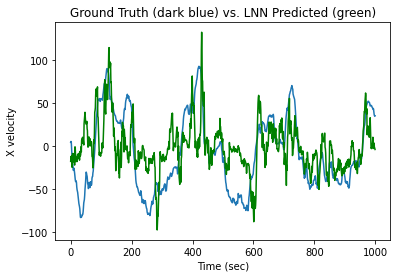

In [137]:
#The blue graph is the ground truth and the green is the LNN prediction values
plt.plot(y_test_all[1][0:1000,0])
plt.plot(y_pred_lnn_all[1][0:1000,0], color='green')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (dark blue) vs. LNN Predicted (green)")



Text(0.5, 1.0, 'Ground Truth (blue) vs. RNN Predicted (red)')

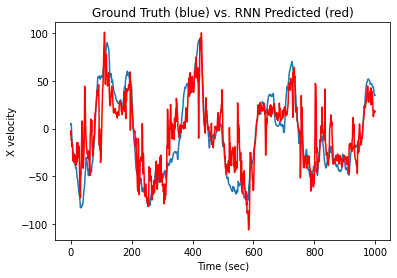

In [141]:
#The blue graph is the ground truth and the red is the RNN prediction values
plt.plot(y_test_all[1][0:1000,0])
plt.plot(y_pred_rnn_all[1][0:1000,0], color='red')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. RNN Predicted (red)")

From the above graphs we can observe that for the testing data the DNN and RNN neural decoder performs well while the LNN decoder performs poorly. The LNN wrongly predicts most of the negative x values where there is a local minima.

### Training Dataset Comparison

Text(0.5, 1.0, 'Ground Truth (blue) vs. DNN Predicted (purple)')

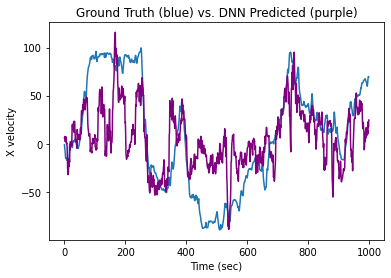

In [143]:
#The blue graph is the ground truth and the purple is the DNN prediction values
plt.plot(y_train_all[1][0:1000,0])
plt.plot(y_train_pred_dnn_all[1][0:1000,0], color='purple')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. DNN Predicted (purple)")


Text(0.5, 1.0, 'Ground Truth (blue) vs. LNN Predicted (green)')

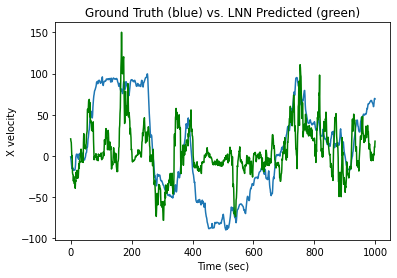

In [144]:
#The blue graph is the ground truth and the green is the LNN prediction values
plt.plot(y_train_all[1][0:1000,0])
plt.plot(y_train_pred_lnn_all[1][0:1000,0], color='green')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. LNN Predicted (green)")


Text(0.5, 1.0, 'Ground Truth (blue) vs. RNN Predicted (red)')

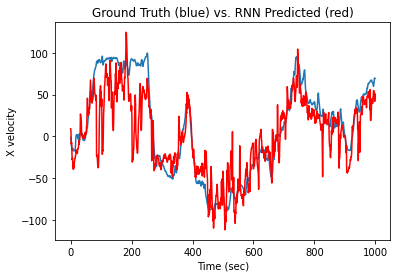

In [145]:
#The blue graph is the ground truth and the purple is the RNN prediction values
plt.plot(y_train_all[1][0:1000,0])
plt.plot(y_train_pred_rnn_all[1][0:1000,0], color='red')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. RNN Predicted (red)")


From the above graphs we can observe that only the RNN Decoder performs well on the training dataset. However there is also too much fluctuations on RNN Predicted on the local minima and maxima points. 

### Validation Dataset Comparison

Text(0.5, 1.0, 'Ground Truth (blue) vs. DNN Predicted (purple)')

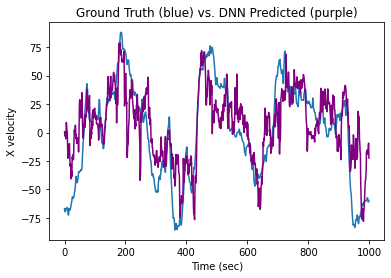

In [148]:
#The blue graph is the ground truth and the purple is the DNN prediction values
plt.plot(y_valid_all[1][0:1000,0])
plt.plot(y_valid_pred_dnn_all[1][0:1000,0], color='purple')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. DNN Predicted (purple)")


Text(0.5, 1.0, 'Ground Truth (blue) vs. LNN Predicted (green)')

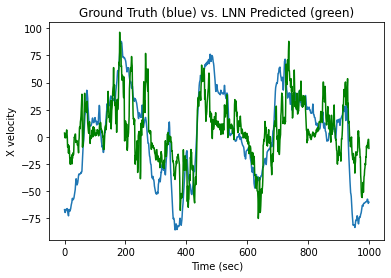

In [149]:
#The blue graph is the ground truth and the green is the LNN prediction values
plt.plot(y_valid_all[1][0:1000,0])
plt.plot(y_valid_pred_lnn_all[1][0:1000,0], color='green')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. LNN Predicted (green)")


Text(0.5, 1.0, 'Ground Truth (blue) vs. RNN Predicted (red)')

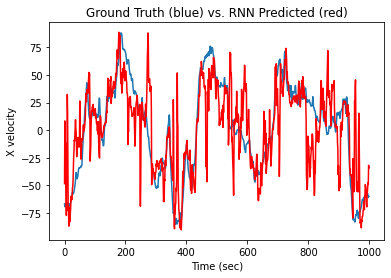

In [150]:
#The blue graph is the ground truth and the green is the LNN prediction values
plt.plot(y_valid_all[1][0:1000,0])
plt.plot(y_valid_pred_rnn_all[1][0:1000,0], color='red')
plt.ylabel("X velocity")
plt.xlabel("Time (sec)")
plt.title("Ground Truth (blue) vs. RNN Predicted (red)")


For the validation dataset all the decoders seem to fit the ground truth well. Although they all have some predicted peak points that do not exist on the ground truth data. 

### Prediction Accuracies

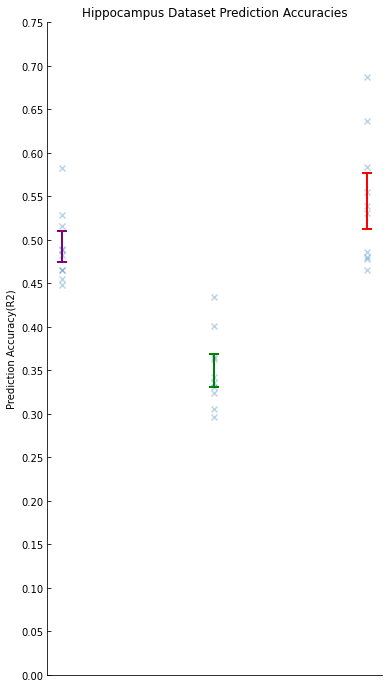

In [155]:
fig, ax = plt.subplots(1,1,squeeze=False,figsize=(6,12)) #Create figure (3 rows by 1 column)
ax = ax.flatten()
plt.ylabel("Prediction Accuracy(R2)")
plt.title("Hippocampus Dataset Prediction Accuracies")


#### Calculate the mean and standard error across cross-validation folds ####
n=mean_r2_dnn.shape[0] #Number of folds
means=([np.mean(mean_r2_dnn), np.mean(mean_r2_lnn), np.mean(mean_r2_rnn)])
err=[np.std(mean_r2_dnn)*np.sqrt(1./n+1./(n-1)), np.std(mean_r2_lnn)*np.sqrt(1./n+1./(n-1)), np.std(mean_r2_rnn)*np.sqrt(1./n+1./(n-1))]
#Note that the standard errors shown are more conservative than using 1/sqrt(n), since the training sets used
#are not independent. See http://www.iro.umontreal.ca/~lisa/bib/pub_subject/language/pointeurs/nadeau_MLJ1597.pdf 




#####PLOT RESULTS######
d=0
colors=['purple', 'green', 'red']

#Plot error bars
ind = np.arange(len(err)) #X values for plotting
for pos, y, yerr, color in zip(ind, means, err, colors): #Loop through methods and plot error bars
    ax[d].errorbar(pos, y, yerr, lw=2, capsize=5, capthick=2, color=color)

#Remove x tick labels
labels = [item.get_text() for item in ax[d].get_xticklabels()]
empty_string_labels = ['']*len(labels)
ax[d].set_xticklabels(empty_string_labels)

#Remove right and top boundaries, and make ticks inward
ax[d].tick_params(direction='in',bottom=0)
ax[d].spines['right'].set_color('none')
ax[d].spines['top'].set_color('none')

#Plot individual R2 values for each fold as an 'x'
scatter_x=np.reshape(np.transpose(np.ones((10,1))*range(3)),(30,1)) #Get x values for plotting (first 10 will have an x value of 0, second 10 will have an x value of 1, etc)
scatter_y=np.concatenate((mean_r2_dnn,mean_r2_lnn,mean_r2_rnn),axis=0) #Y values for plotting

#Y values for plotting
colors_list=[] #Create a list of the colors that should be used when plotting each 'x'
ax[d].scatter(scatter_x,scatter_y,marker='x',alpha=0.3)

#Set y axis limits and ticks
ax[d].set_ylim([.25, .75])
ax[d].set_yticks(np.arange(0,.751,.05))


plt.show()



The above graph is the prediction accuracy for the whole dataset for all of the decoders. The prediction accuracy here is calculated by the R2 distance in the **get_R2(...)** function. As we observe above the LNN decoder has the worst prediction accuracy. This expeced as there seems to be no linear relationship between the inputs and outputs for the hippocampus dataset. The RNN decoder has the highest prediction accuracy, then the DNN decoder. This is because RNNs are a powerful and robust type of neural network, because it possesses an internal memory by its design. They use their internal state memory to process sequences of inputs which is very similar to the role of hippocampus. However one interesting thing about the graph above is that the uncertainty is higher in RNN decoder while it is lower in DNN decoder.

## The Effectiveness of Deep Learning Models in Neural Decoding

Now that we have compared several neural networks for their performance in neural decoding, we may talk more about the limitations on all of these models as neural decoders. Even they surpass many traditional machine learning techniques [1], they require a lot of data and considerable size for the network. I have used 200 units for each hidden layer but if increased it will be most likely do much better. If I tried to feed more hippocampus data to the network it will most likely increase the prediction accuracy. Another important factor is the noise in data. For example, fMRI signals have far higher noise levels than spikes. As the noise level goes up, linear techniques become more appropriate, even though they have a lower prediction accuracy which may have been masked by noise.


All our decoding was done “offline,” meaning that the decoding occurred after the recording, and was not part of a control loop. This type of decoding is useful for determining how information in a brain area relates to an external variable. However, for engineering applications such as BMIs (Nicolas-Alonso and Gomez-Gil, 2012; Kao et al., 2014) [1], the goal is to decode information (e.g., predict movements) in real time.

Feature importance refers to the determination of which inputs most affect a machine learning model’s predictions. For decoding, feature importance methods could be used to ask which neurons are important for making the predictions, or if multiple brain areas are input into the decoder, which of these brain regions matter. We have only used one region of the brain to make a prediction about the firing rate of a neuron in that region, although we know that a neuron firing in another region of the brain may trigger the firing of some neurons in another region of the brain. Also, we did not drop any features while training the neural network. One possibility is to use the Dropout layer (even though it is generally used to avoid overfitting) to drop some neurons which are non-contributing.
Layers that include spatial attention and methods for performing feature attribution have been developed to understand what parts of the input are important for prediction.These methods could be used to attribute what channels, neurons (e.g. of different genetically defined cell types) or time-points are most salient for neural decoding [2].



As the capability to generate ever larger datasets develops with automated, long-term experimental setups for single animals and large-scale recordings across multiple animals, deep learning is well poised to take advantage of this flood of data [2]. As dataset sizes increase, this will also allow more features to be learned through data-driven network training.




## Bibliography

[1] Glaser, Joshua I et al. “Machine Learning for Neural Decoding.” eNeuro vol. 7,4 ENEURO.0506-19.2020. 31 Aug. 2020, doi:10.1523/ENEURO.0506-19.2020

[2] Livezey, Jesse A., and Glaser, Joshua I. Deep learning approaches for neural decoding across architectures and recording modalities. United States: N. p., 2020. Web. doi:10.1093/bib/bbaa355